# $t^*$ as tuning parameter

#### Import

In [3]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# import OGGM modules
import oggm
from oggm import cfg, graphics, utils
from oggm.utils import get_demo_file, get_rgi_glacier_entities, rmsd
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, massbalance, flowline, inversion

# import my modules
import sys
sys.path.append('../code/')
from utils import rmsd_anomaly

## Initialize

In [12]:
# load default parameter file
cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/working_example/'
cfg.PATHS['working_dir'] = wdir

# using intersects
cfg.PARAMS['use_intersects'] = True

# define big border
cfg.PARAMS['border'] = 250

# set climate/massbalance hyper parameters for HistAlp dataset
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-04-24 14:57:08: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


## Preprocessing

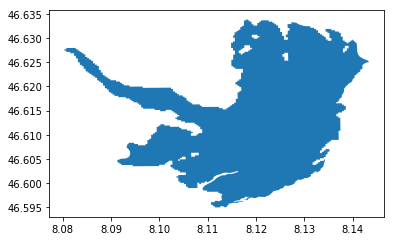

In [5]:
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]
rgi_df.plot()

In [6]:
# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

In [7]:
# prepare glacier directory
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

### GIS

In [8]:
# GIS tasks
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)
gdir

2019-04-24 14:55:34: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-04-24 14:55:34: oggm.core.gis: (RGI60-11.01270) glacier_masks


<oggm.GlacierDirectory>
  RGI id: RGI60-11.01270
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 9.023 km2
  Lon, Lat: (8.11933, 46.6143)
  Grid (nx, ny): (592, 583)
  Grid (dx, dy): (52.0, -52.0)

### Centerlines

In [9]:
# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-04-24 14:55:36: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-04-24 14:55:36: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-04-24 14:55:37: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-04-24 14:55:41: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-04-24 14:55:43: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-04-24 14:55:46: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-04-24 14:55:46: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-04-24 14:55:47: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction


### Climate and mass balance parameters

In [24]:
# process the HistAlp climate file
climate.process_histalp_data(gdir)
ci = gdir.read_pickle('climate_info')
ci

2019-04-24 15:12:22: oggm.core.climate: (RGI60-11.01270) process_histalp_data


{'baseline_climate_source': 'HISTALP',
 'baseline_hydro_yr_0': 1802,
 'baseline_hydro_yr_1': 2014}

In [62]:
t_star = 1802
climate.local_t_star(gdir, tstar=t_star)
climate.mu_star_calibration(gdir)

2019-04-24 15:22:29: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-04-24 15:22:29: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1909
2019-04-24 15:22:29: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


### Mass balance

In [63]:
# read climate info file
ci = gdir.read_pickle('climate_info')
y0 = ci['baseline_hydro_yr_0']
y1 = ci['baseline_hydro_yr_1']

In [64]:
# istance mass balance model using the historic climate file
mb_model = massbalance.PastMassBalance(gdir)

### Inversion

In [65]:
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
inv_glen_a = cfg.PARAMS['inversion_glen_a']
inversion.mass_conservation_inversion(gdir, glen_a=inv_glen_a)
inversion.filter_inversion_output(gdir)

2019-04-24 15:22:32: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2019-04-24 15:22:32: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2019-04-24 15:22:32: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


2019-04-24 15:22:33: oggm.core.inversion: (RGI60-11.01270) distribute_thickness_interp


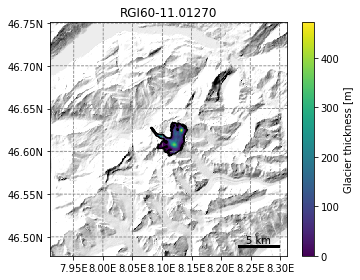

In [66]:
# visualize ice thickness
inversion.distribute_thickness_interp(gdir)
graphics.plot_distributed_thickness([gdir])

### Dynamic model

In [67]:
# finalize the preporcessing
flowline.init_present_time_glacier(gdir)

2019-04-24 15:22:34: oggm.core.flowline: (RGI60-11.01270) init_present_time_glacier


## Model

In [68]:
# read needed file
ci =  gdir.read_pickle('climate_info')
fls = gdir.read_pickle('model_flowlines')

In [69]:
# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model, y0=y0)

In [70]:
# run model over entire HistAlp period
run_ds, diag_ds = model.run_until_and_store(y1)

## Results

In [114]:
length = pd.DataFrame(columns=np.arange(y0,y1+1))
length.index.name = 't_star'
length.loc[t_star] = diag_ds.length_m.to_dataframe()['length_m']
length

,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
t_star,,,,,,,,,,,,,,,,,,,,,
1997,6136.0,6240.0,6240.0,6240.0,6136.0,6240.0,6344.0,6240.0,6344.0,6344.0,...,4160.0,4264.0,4160.0,3952.0,3848.0,3848.0,3640.0,3640.0,3536.0,3536.0


In [84]:
from utils import get_leclercq_length
length_ref = get_leclercq_length(rgi_id='11.01270')

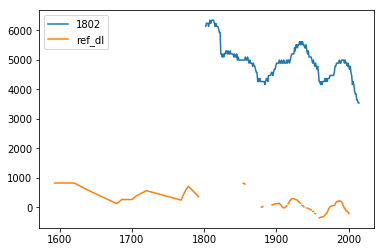

In [85]:
length = length.append(length_ref.T)
length.T.plot()

## Look at results of script

In [122]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

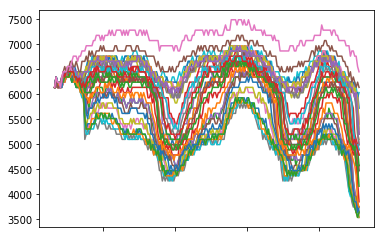

In [124]:
# define path
fn = '/Users/oberrauch/work/grindelwald/data/length_t_star.csv'
length = pd.read_csv(fn, index_col=0)
length.iloc[:-1].T.plot(legend=False)

In [138]:
length_model.diff(axis=1)

,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
t_stars,,,,,,,,,,,,,,,,,,,,,
1817,NaN,104.0,0.0,0.0,0.0,104.0,0.0,0.0,0.0,104.0,...,-104.0,-416.0,-208.0,-104.0,-104.0,-104.0,104.0,-208.0,-104.0,-208.0
1822,NaN,104.0,0.0,-104.0,0.0,208.0,0.0,104.0,0.0,0.0,...,-104.0,-312.0,-208.0,-312.0,104.0,-104.0,-104.0,0.0,-312.0,0.0
1827,NaN,208.0,-104.0,0.0,-104.0,104.0,0.0,104.0,104.0,0.0,...,-104.0,-104.0,104.0,-104.0,-104.0,-416.0,-208.0,-208.0,-104.0,0.0
1832,NaN,208.0,-208.0,0.0,0.0,104.0,0.0,104.0,0.0,0.0,...,-104.0,-208.0,-208.0,-104.0,-104.0,104.0,-208.0,104.0,-520.0,208.0
1837,NaN,208.0,-208.0,104.0,0.0,104.0,0.0,0.0,104.0,-104.0,...,-104.0,-104.0,-312.0,-312.0,-104.0,-104.0,-104.0,-104.0,-104.0,0.0
1842,NaN,208.0,-208.0,0.0,104.0,0.0,104.0,104.0,-104.0,104.0,...,-520.0,0.0,-312.0,-104.0,0.0,-104.0,0.0,-104.0,-208.0,-104.0
1847,NaN,208.0,-208.0,104.0,-104.0,0.0,208.0,0.0,0.0,0.0,...,104.0,-208.0,-104.0,104.0,-208.0,-416.0,-208.0,-208.0,-104.0,104.0
1852,NaN,208.0,-208.0,0.0,104.0,104.0,-104.0,208.0,0.0,0.0,...,-104.0,-104.0,104.0,-416.0,-208.0,-208.0,-104.0,-104.0,-104.0,-104.0
1857,NaN,208.0,-208.0,104.0,-104.0,104.0,104.0,0.0,104.0,0.0,...,-104.0,-104.0,104.0,-208.0,104.0,-104.0,-104.0,-104.0,-624.0,-104.0


In [176]:
# get modeled length changes
length_model = length.drop('ref_dl').dropna(axis=1)
length_model.columns = length_model.columns.astype(int)
length_model.head()

,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
t_stars,,,,,,,,,,,,,,,,,,,,,
1817,6136.0,6240.0,6240.0,6240.0,6240.0,6344.0,6344.0,6344.0,6344.0,6448.0,...,5824.0,5408.0,5200.0,5096.0,4992.0,4888.0,4992.0,4784.0,4680.0,4472.0
1822,6136.0,6240.0,6240.0,6136.0,6136.0,6344.0,6344.0,6448.0,6448.0,6448.0,...,5824.0,5512.0,5304.0,4992.0,5096.0,4992.0,4888.0,4888.0,4576.0,4576.0
1827,6136.0,6344.0,6240.0,6240.0,6136.0,6240.0,6240.0,6344.0,6448.0,6448.0,...,4888.0,4784.0,4888.0,4784.0,4680.0,4264.0,4056.0,3848.0,3744.0,3744.0
1832,6136.0,6344.0,6136.0,6136.0,6136.0,6240.0,6240.0,6344.0,6344.0,6344.0,...,5512.0,5304.0,5096.0,4992.0,4888.0,4992.0,4784.0,4888.0,4368.0,4576.0
1837,6136.0,6344.0,6136.0,6240.0,6240.0,6344.0,6344.0,6344.0,6448.0,6344.0,...,6032.0,5928.0,5616.0,5304.0,5200.0,5096.0,4992.0,4888.0,4784.0,4784.0


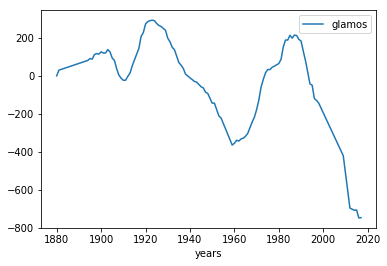

In [177]:
# get reference length
fn = '/Users/oberrauch/work/grindelwald/data/length_ref_glamos.csv'
length_ref = pd.read_csv(fn, index_col=0)
length_ref.plot()

In [192]:
climate.local_t_star(gdir)
climate.mu_star_calibration(gdir)
loc_mu_star = gdir.read_json('local_mustar')
loc_mu_star

2019-04-24 17:04:20: oggm.core.climate: (RGI60-11.01270) local_t_star
2019-04-24 17:04:20: oggm.core.climate: (RGI60-11.01270) local mu* computation for t*=1909
2019-04-24 17:04:20: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


{'rgi_id': 'RGI60-11.01270',
 't_star': 1909,
 'bias': 59.39856206984309,
 'mu_star_glacierwide': 161.86710800199404,
 'mu_star_per_flowline': [161.867108001994,
  161.867108001994,
  161.867108001994,
  161.867108001994],
 'mu_star_flowline_avg': 161.867108001994,
 'mu_star_allsame': True}

Text(1910,0.53,'default $t^*$: 1909')

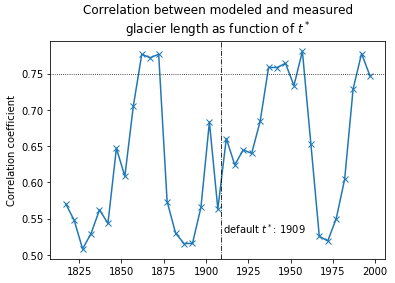

In [208]:
# compute correlation
corr = [pd.concat([length_ref, l_mod], axis=1).corr().iloc[0,1] for t_star, l_mod in length_model.iterrows()]
corr = pd.Series(corr, index=length_model.index)
corr.index = corr.index.astype(int)
corr.plot(marker='x')
plt.axhline(0.75, c='k', ls=':', lw=0.8, label='arbitrary corr. threshold')
plt.axvline(loc_mu_star['t_star'], c='k', ls='-.', lw=0.8, label='default $t^*$')
plt.title('Correlation between modeled and measured\nglacier length as function of $t^*$')
plt.ylabel('Correlation coefficient')
plt.xlabel('')
plt.text(1909+1, 0.53, 'default $t^*$: ' + str(loc_mu_star['t_star']))

In [209]:
t_stars

array([1817, 1822, 1827, 1832, 1837, 1842, 1847, 1852, 1857, 1862, 1867,
       1872, 1877, 1882, 1887, 1892, 1897, 1902, 1907, 1912, 1917, 1922,
       1927, 1932, 1937, 1942, 1947, 1952, 1957, 1962, 1967, 1972, 1977,
       1982, 1987, 1992, 1997])

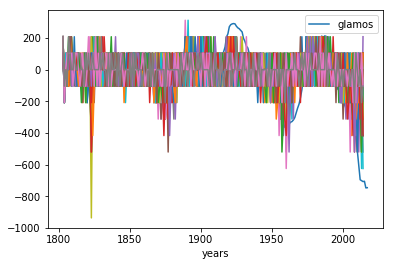

In [156]:
length_ref.plot()
length_model.T.plot(ax = plt.gca(), legend=False)

In [21]:

# define range of prcp factors
prcp_facs = np.array(['{:.2f}'.format(f) for f in np.linspace(1, 1.75, 16)]).astype(float)
# define scaling factors for the creep parameters
factors = np.concatenate((np.linspace(0.1, 1, 9, endpoint=False),
                          np.linspace(1, 20, 20)))

# define empty containers
correlation = pd.DataFrame(index=factors, columns=prcp_facs)
rmsd = pd.DataFrame(index=factors, columns=prcp_facs)
amp_diff = pd.DataFrame(index=factors, columns=prcp_facs)
xcorr = pd.DataFrame(index=factors, columns=prcp_facs)
xcorr_shift = pd.DataFrame(index=factors, columns=prcp_facs)

# iterate over all precipitation factors
for prcp_fac in prcp_facs:
    fn = os.path.join(folder, filename.format(prcp_fac))
    df = pd.read_csv(fn, index_col=0)
    correlation.loc[:, prcp_fac] = df.correlation
    rmsd.loc[:, prcp_fac] = df.rmsd
    amp_diff.loc[:, prcp_fac] = df.amp_diff
    xcorr.loc[:, prcp_fac] = df.xcorr
    xcorr_shift.loc[:, prcp_fac] = df.xcorr_shift

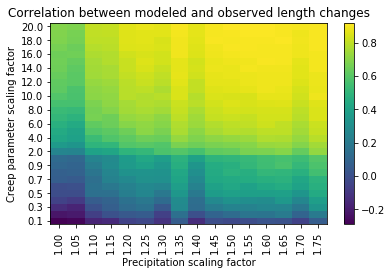

In [22]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(correlation.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Correlation between modeled and observed length changes')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/correlation.pdf')

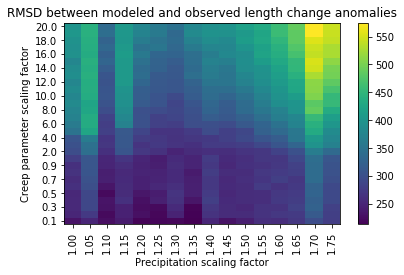

In [23]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(rmsd.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('RMSD between modeled and observed length change anomalies')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/rmsd.pdf')

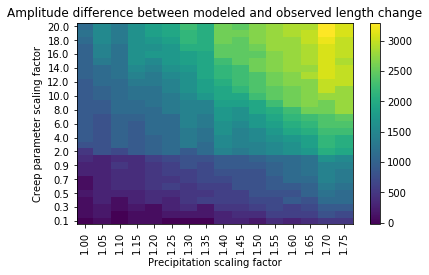

In [24]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(amp_diff.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Amplitude difference between modeled and observed length change')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/amp_diff.pdf')

In [28]:
# define threshold of amplitude difference in meters
threshold = 250
# get parameter combinations
amp_diff[amp_diff <= threshold].dropna(how='all')

,1.0,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75
0.1,-31.0,73.0,-31.0,73.0,73.0,-31.0,-31.0,-31.0,NaN,NaN,177.0,NaN,NaN,NaN,NaN,NaN
0.2,73.0,177.0,-31.0,73.0,73.0,177.0,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,73.0,177.0,73.0,177.0,73.0,NaN,NaN,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,73.0,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.7,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


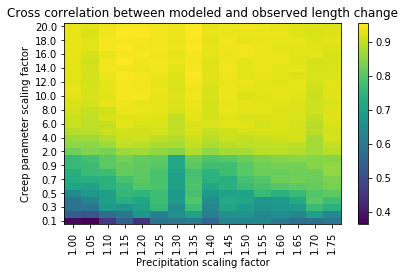

In [26]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(xcorr.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Cross correlation between modeled and observed length change')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/xcorr.pdf')

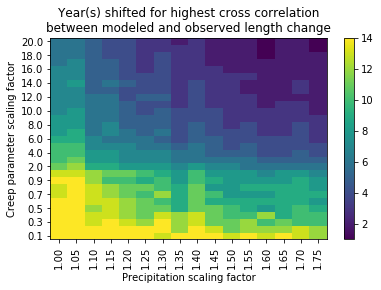

In [27]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(xcorr_shift.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Year(s) shifted for highest cross correlation\nbetween modeled and observed length change')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/xcorr_shift.pdf')

## Look at the results of the second  cross correlation
This cross correlation was performed using the `A param` and the `prcp_scaling_factor`, without running the mass balance calbration

In [1]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define precipation scaling factors
prcp_facs = np.array(['{:.2f}'.format(f) for f in np.linspace(1, 1.75, 16)]).astype(float)

In [7]:
# define path
folder = '/Users/oberrauch/work/grindelwald/data/length_corr_no_mb_calib/'
filename = 'length_corr_prcp_fac_{:.2f}.csv'

# define range of prcp factors
prcp_facs = np.array(['{:.2f}'.format(f) for f in np.linspace(1, 1.75, 16)]).astype(float)
# define scaling factors for the creep parameters
factors = np.concatenate((np.linspace(0.1, 1, 9, endpoint=False),
                          np.linspace(1, 20, 20)))

# define empty containers
correlation = pd.DataFrame(index=factors, columns=prcp_facs)
rmsd = pd.DataFrame(index=factors, columns=prcp_facs)
amp_diff = pd.DataFrame(index=factors, columns=prcp_facs)

# iterate over all precipitation factors
for prcp_fac in prcp_facs:
    fn = os.path.join(folder, filename.format(prcp_fac))
    df = pd.read_csv(fn, index_col=0)
    correlation.loc[:, prcp_fac] = df.correlation
    rmsd.loc[:, prcp_fac] = df.rmsd
    amp_diff.loc[:, prcp_fac] = df.amp_diff

In [33]:
# plot countour lines [Y/N]
contour = False

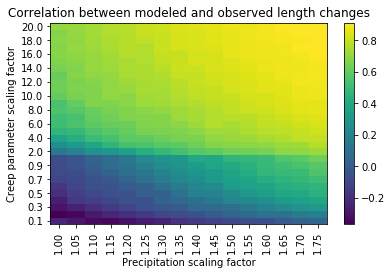

In [34]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(correlation.values.astype(float))
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Correlation between modeled and observed length changes')
# add contour lines
if contour:
    cs = ax.contour(correlation.values.astype(float), colors='k')
    ax.clabel(cs, fmt='%.2f')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/correlation.pdf')

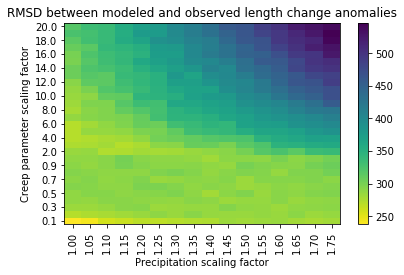

In [35]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(rmsd.values.astype(float), cmap='viridis_r')
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('RMSD between modeled and observed length change anomalies')
# add contour lines
if contour:
    cs = ax.contour(rmsd.values.astype(float), colors='k')
    ax.clabel(cs, fmt='%.0f')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/rmsd.pdf')

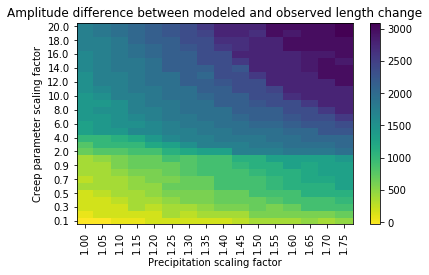

In [36]:
# create figuer and axes
fig = plt.figure()
ax = fig.add_axes([0.17, 0.18, 0.8, 0.7])
# plot
im = ax.pcolormesh(amp_diff.values.astype(float), cmap='viridis_r')
# colorbar
plt.colorbar(im)
# labels, title, ...
ax.set_xticks(np.arange(0.5, 16, 1))
ax.set_xticklabels(['{:.2f}'.format(f) for f in np.arange(1, 1.8, 0.05)], rotation=90)
ax.set_xlabel('Precipitation scaling factor')
ax.set_yticks(np.arange(0.5, 29, 2))
ax.set_yticklabels(['{:.1f}'.format(f) for f in factors[::2]])
ax.set_ylabel('Creep parameter scaling factor')
ax.set_title('Amplitude difference between modeled and observed length change')
# add contour lines
if contour:
    cs = ax.contour(amp_diff.values.astype(float), colors='k')
    ax.clabel(cs, fmt='%.0f')

plt.savefig('/Users/oberrauch/work/grindelwald/figures/glen_a/amp_diff.pdf')

In [11]:
# define threshold of amplitude difference in meters
threshold = 250
# get parameter combinations
amp_diff[amp_diff <= threshold].dropna(how='all')

,1.0,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75
0.1,-31.0,-31.0,73.0,73.0,177.0,177.0,177.0,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,73.0,177.0,177.0,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,177.0,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,177.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
